# ProtEx

The ultimate goal of this project is to be able to detect selenoproteins in databases which have been incorrectly truncated at the first instance of a Sec codon, which shares the same code (AUG) as the canonical stop codon. For this task, we are planning to apply the pre-trained ESM transformer.

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Fixing some of the issues I'm having with importing modules. 
import sys
sys.path.append('/home/prichter/Documents/protex/src/')

from src.dataset import *
from src.dataset import SequenceDataset
from src.esm import ESMClassifier, esm_train, esm_test
from src.linear import LinearClassifier, linear_train, linear_test
import scipy.stats as stats
import pandas as pd
import torch
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import transformers
from io import StringIO

from plot import *

In [5]:
def download_data_from_google_drive(url):
    '''
    Read in CSV data from Google Drive into a pandas DataFrame. 
    '''
    text = requests.get(url).text
    df = pd.read_csv(StringIO(text))

    return df

## Data and preprocessing

All amino acid sequences were obtained from the UniProt database. The data is in FASTA format for compatibility with the CD-Hit sequence clustering tool.
1. `./data/sec.fasta` All peptide sequences tagged in the UniProt database as containing a selenocysteine residue (there are about 20,000). All sequences have been truncated at the first selenocysteine. 
2. `./data/short.fasta` This dataset serves as true positive instances of short proteins which are *not* incorrectly truncated. This file was generated by using a Gaussian KDE to approximate a length distribution of truncated selenoproteins (in `sec_trunc.fasta`), sampling from the distribution, and downloading sequences from UniProt which match the length.
3. `./data/all.fasta` A combination of `sec_trunc.fasta` and `short.fasta`.



### Generating train and test data

The The CD-Hit protein clustering tool was used to organize the sequences contained in `all.fasta` into clusters with 80 percent similarity. This was done using the command `cd-hit -i all.fasta -o all -n 5 -c 0.8`. Clustering the sequences, and organizing the training and testing sets such that no cluster spans the two, helps to ensure that the test accuracy captures whether or not the model is generalizing (similar to the approach [here](https://www.biorxiv.org/content/10.1101/626507v4.full)). 

Using a greedy partitioning algorithm, the combined dataset was split into a train and test set (with a roughly 75%/25% train/test split). This partitioning approach ensures that no cluster group spans both train and test datasets, for the reasons mentioned above. 

After generating the train and test datasets, I saved the data to CSV files to avoid having to re-run cells more than I need to. These files are also stored in the data directory, and contain the amino acid sequences, unique identifiers, and cluster number.

After Generating the train and test data, it was uploaded to Google Drive, where it can be downloaded and converted to `pd.DataFrame` objects using the code in the cell below. This allows the data to be accessed from any machine. 

After it's downloaded, the data is loaded into a `SequenceDataset` object, which is defined in the `dataset.py` module. This class inherits from the `torch.utils.data.Dataset` class, and allows the data to be easily processed into batches and shuffled using the `torch.utils.data.DataLoader` object. 

In [6]:
# TODO: Something weird is happening with the label generation when I read things in from Google Drive, so just doing
# it from local files for now. 

# The data is stored in Google Drive at the following URLs. We can use the file ID to download the data. 
# train_data_url = 'https://drive.google.com/file/d/11vKxUfYyEUBe1UtQoxezwrYdWuqS7Alx/view?usp=sharing'
# test_data_url = 'https://drive.google.com/file/d/1D43lFsvTAy3n3YgyrwSvw9nFfQl3_9F4/view?usp=sharing'


train_data_url = 'https://drive.google.com/uc?export=download&id=11vKxUfYyEUBe1UtQoxezwrYdWuqS7Alx'
test_data_url = 'https://drive.google.com/uc?export=download&id=1D43lFsvTAy3n3YgyrwSvw9nFfQl3_9F4'
sec_fasta_url = 'https://drive.google.com/uc?export=download&id=1m3LBTMxaGZarOKgSHejRCkfc7cM7xAsv'

# Get the selenoprotein data for generating the labels. 
# sec_data = download_data_from_google_drive(sec_fasta_url, format='fasta')
sec_data = fasta_to_df('/home/prichter/Documents/protex/data/sec.fasta') 

# TODO: I should probably just add the labels as a column. 
# train_data = SequenceDataset(download_data_from_google_drive(train_data_url, format='csv'), sec_data=sec_data)
# test_data = SequenceDataset(download_data_from_google_drive(test_data_url, format='csv'), sec_data=sec_data)

train_data = SequenceDataset(pd.read_csv('/home/prichter/Documents/protex/data/train.csv'), sec_data=sec_data)
test_data = SequenceDataset(pd.read_csv('/home/prichter/Documents/protex/data/test.csv'), sec_data=sec_data)

# Load the data into PyTorch DataLoader objects.
train_loader = DataLoader(train_data, shuffle=True, batch_size=32)
test_loader = DataLoader(test_data, shuffle=False, batch_size=32)


## Sequence classification

### Fine-tuning ESM for sequence classification 

The following block of code takes a couple of days to run. I executed it as a script in a Google Compute VM, and saved the losses and fine-tuned model. I tried to configure this so that the model weights could be automatically loaded from Google Drive, but it seems as though the model is too large for this ("Google Drive can't scan this file for viruses."). So, I just pushed the entire pickled model to GitHub (not great, I know, but should work for now.)

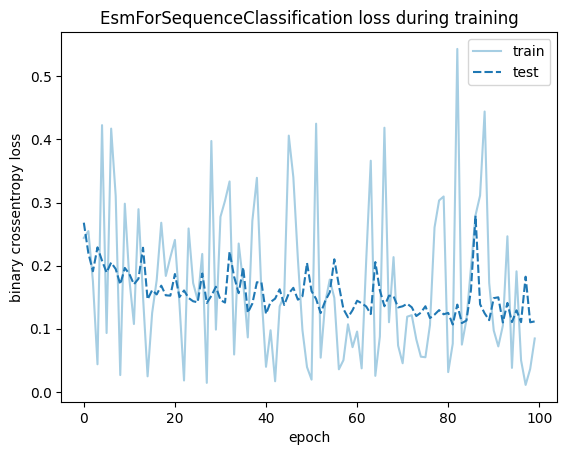

In [10]:
model_esm = torch.load('model_esm.pickle', map_location=torch.device('cpu'))
losses_esm = pd.read_csv('losses_esm.csv', usecols=['train', 'test'])
# print(losses_esm.head())

fig, ax = plt.subplots(1)
sns.lineplot(data=losses_esm, ax=ax, palette='Paired')
ax.set_title('EsmForSequenceClassification loss during training')
ax.set_ylabel('binary crossentropy loss')
ax.set_xlabel('epoch')
fig.savefig('esm_loss_during_training.png', format='png')
plt.show()

### Training the LinearClassifier benchmark


In [7]:
model_linear = LinearClassifier() # Uses default embedding dim of 64.
losses_linear = linear_train(model_linear, train_loader, test_loader=test_loader, n_epochs=300)

Training classifier...: 100%|██████████| 300/300 [20:43<00:00,  4.15s/it]


In [ ]:
# Save the model weights. 
# torch.save(model_linear, 'model_linear.pickle')

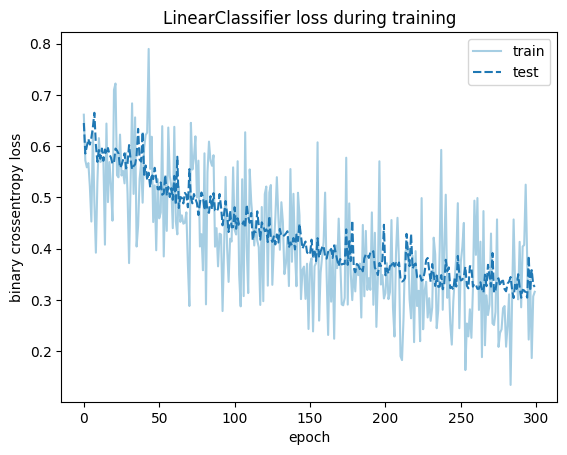

In [9]:
fig, ax = plt.subplots(1)
sns.lineplot(data=pd.DataFrame(losses_linear), ax=ax, palette='Paired')
ax.set_title('LinearClassifier loss during training')
ax.set_ylabel('binary crossentropy loss')
ax.set_xlabel('epoch')
fig.savefig('linear_loss_during_training_random_init.png', format='png')
plt.show()

### Evaluation

To evaluate the models, prediction accuracy was computed for each, as well as the test loss. 

In [10]:
# First, load each trained model from their pickle files. 
model_esm = torch.load('model_esm.pickle', map_location=torch.device('cpu'))
model_linear = torch.load('model_linear.pickle') # This is the model with Xavier initialization. 


In [22]:
# esm_test_loss, esm_accuracy = esm_test(model_esm, test_loader)
print('EsmForSequenceClassification test loss:', esm_test_loss.item())
print('EsmForSequenceClassification classification accuracy:', esm_accuracy)

EsmForSequenceClassification test loss: 0.1365031749010086
EsmForSequenceClassification classification accuracy: 0.95412457


In [19]:
linear_test_loss, linear_accuracy = linear_test(model_linear, test_loader)
print('LinearClassifier test loss:', linear_test_loss.item())
print('LinearClassifier classification accuracy:', linear_accuracy)

Calculating batch loss...: 100%|██████████| 297/297 [00:00<00:00, 1369.29it/s]

LinearClassifier test loss: 0.3180880546569824
LinearClassifier classification accuracy: 0.8717382


Just to confirm that fine-tuning the ESM model on the training data improved performance, I also want to check the classification loss. I should note that I am not sure how the weights of the ESM classification head are initialized (i.e. whether they are random, Xavier, pre-trained, etc.). 

In [30]:
# model_esm_original = ESMClassifier() # Don't train this one!

# esm_original_test_loss, esm_original_accuracy = esm_test(model_esm_original, test_loader)
print('EsmForSequenceClassification test loss:', esm_original_test_loss.item())
print('EsmForSequenceClassification classification accuracy:', esm_original_accuracy)

EsmForSequenceClassification test loss: 0.685573160648346
EsmForSequenceClassification classification accuracy: 0.61858165
